In [1]:

import sys
sys.path.append("./modules")


In [16]:
# Import general modules
from nansat import Nansat, Domain, NSR
import os 

# Import temporal modules needed for testing plotting
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Import SAR forecasting modules
import config
import s1_preparation
import domains_preparation
import SAR1_SAR2_drift_retrivial

# Import variables
from config import path_to_HH_files, path_to_HV_files, safe_folder 
from config import output_folder, input_folder
from config import S1_prod_regex, S1_safe_regex
from config import lon, lat, X, Y, proj4, srs

In [3]:
# 1. Prepare SAR pairs

# Collect Sentinel SAFE objects for files in safe directory.
safe_objects = s1_preparation.collect_sentinel_files(safe_folder, path_to_HH_files, path_to_HV_files,  S1_safe_regex, S1_prod_regex)

# Get pairs of Sentinel SAFE objects where their timestamps are within 50 hours of each other.
sar_pairs = s1_preparation.get_pairs_within_time_limit(safe_objects, hours = 50)

# Print details for each pair.
for index, pair in enumerate(sar_pairs, start=1):  # start=1 makes the index start from 1
    print(f'Pair {index}:')
    print(f'SAR1: {pair[0].filename} \ntimestamp: {pair[0].timestamp}\n'
          f'SAR2: {pair[1].filename} \ntimestamp: {pair[1].timestamp}')

Pair 1:
SAR1: S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1.SAFE 
timestamp: 2022-11-20 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221122T074535_20221122T074639_046004_05816B_9FC9.SAFE 
timestamp: 2022-11-22 07:45:35
Pair 2:
SAR1: S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB.SAFE 
timestamp: 2023-02-12 08:01:51
SAR2: S1A_EW_GRDM_1SDH_20230214T074531_20230214T074635_047229_05AAC8_4014.SAFE 
timestamp: 2023-02-14 07:45:31


In [4]:
# 2.1. Prepare nansat objects and domains (for each sar pair)

#Prepare nansat objects for HV polarisation
n1_hv, n2_hv, output_dir_name, plots_dir_hv =  domains_preparation.prepare_nansat_objects(sar_pairs[1][0], sar_pairs[1][1], output_folder, polarisation='HV')

#Prepare nansat objects for HH polarisation
n1_hh, n2_hh, output_dir_name, plots_dir_hh =  domains_preparation.prepare_nansat_objects(sar_pairs[1][0], sar_pairs[1][1], output_folder, polarisation='HH')




VMIN:  -3.9498636960983275
VMAX:  5.663959283828735
VMIN:  -3.5571017265319824
VMAX:  5.484246134757996
Successfully created /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20230212T080151_20230214T074531
Successfully created /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20230212T080151_20230214T074531/HV_plots
VMIN:  -3.774366235733032
VMAX:  5.102492332458496
VMIN:  -3.0308663845062256
VMAX:  4.180728316307068
Successfully created /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20230212T080151_20230214T074531
Successfully created /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20230212T080151_20230214T074531/HH_plots


In [5]:
# 2.2  Define model domain (mod_dom) for comparing drift and comparison (dst_dom) domain to compare SAR images (real and forecasted)

# Prepare subset model grid for domains and pattern matching
X_subset, Y_subset, lon_subset, lat_subset = domains_preparation.prepare_grid(n1_hv, n2_hv, srs, X, Y, lon, lat, buffer=0)

# Set a model domain
mod_res = 2500
mod_dom = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data) - mod_res * 2} {max(X_subset.data) + mod_res} {max(Y_subset.data)} -tr {mod_res} {mod_res}')


lon1pm, lat1pm = mod_dom.get_geolocation_grids()
x, y = mod_dom.get_geolocation_grids(dst_srs=srs)

# Set a comparison domain 
dst_res = 100
dst_dom = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data) - dst_res * 2} {max(X_subset.data) + dst_res} {max(Y_subset.data)} -tr {dst_res} {dst_res}')

domains_preparation.plot_borders(mod_dom, n1_hv, n2_hv, output_dir_name) # borders for hh and hv are the same

'/home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20230212T080151_20230214T074531/General_plots/images_vs_domain_borders.png'

In [6]:
# 3.   Retrieve reference drift
# 3.1. Run feature tracking and pattern matching for HV

# Run feature tracking and plot results 
c1_hv, r1_hv, c2_hv, r2_hv = SAR1_SAR2_drift_retrivial.run_feature_tracking(n1_hv, n2_hv, plots_dir_hv)

#Run pattern matching and plot results
upm_hv, vpm_hv, apm_hv, rpm_hv, hpm_hv, ssim_hv, lon2pm_hv, lat2pm_hv = SAR1_SAR2_drift_retrivial.run_pattern_matching(plots_dir_hv, x, y, 
                                                           lon1pm, lat1pm, n1_hv, c1_hv, r1_hv, n2_hv, c2_hv, r2_hv, srs, 
                                                           min_border=10, #200,
                                                           max_border=10, #200,
                                                           angles=[-9,-6, -3, 0, 3, 6, 9])
                                                           #angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 37701
Domain filter: 50000 -> 48850
Keypoints matched 4.030477046966553
Ratio test 0.600000 found 1552 keypoints
MaxDrift filter: 1552 -> 1552
LSTSQ filter: 1552 -> 1523


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


90% 01277.1 04553.2 02290.0 04743.0 +09.0 0.15 0.88 0.10247% 02382.9 02419.4 03180.0 02474.0 -09.0 0.42 7.96 0.2942% 01948.2 02116.4 02769.0 02187.0 -03.0 0.55 8.88 0.4255% 03326.0 02943.7 04114.0 02973.0 +09.0 0.20 1.38 0.1060% 03076.0 03162.4 03839.0 03209.0 -03.0 0.60 8.90 0.52
 Pattern matching - OK! ( 14 sec)


In [7]:
# 3.2. Run feature tracking and pattern matching for HH

# HH Processing
# Run feature tracking and plot results 
c1_hh, r1_hh, c2_hh, r2_hh = SAR1_SAR2_drift_retrivial.run_feature_tracking(n1_hh, n2_hh, plots_dir_hh)

#Run pattern matching and plot results
upm_hh, vpm_hh, apm_hh, rpm_hh, hpm_hh, ssim_hh, lon2pm_hh, lat2pm_hh = SAR1_SAR2_drift_retrivial.run_pattern_matching(plots_dir_hh, x, y, 
                                                           lon1pm, lat1pm, n1_hh, c1_hh, r1_hh, n2_hh, c2_hh, r2_hh,srs, 
                                                           min_border=10, #200,
                                                           max_border=10, #200,
                                                           angles=[-9,-6, -3, 0, 3, 6, 9])
                                                           #angles=[-50, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 50 ])

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 43258
Domain filter: 50000 -> 48486
Keypoints matched 4.202576398849487
Ratio test 0.600000 found 489 keypoints
MaxDrift filter: 489 -> 489
LSTSQ filter: 489 -> 481


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


95% 01313.7 04744.7 02191.0 05024.0 -03.0 0.13 2.80 0.0845% 01092.4 00177.2 01875.0 00433.0 +09.0 0.19 4.71 0.1416% 02335.3 00826.3 03136.0 00886.0 -03.0 0.49 7.70 0.3558% 02598.2 02945.4 03343.0 03019.0 +00.0 0.14 4.12 0.0862% 02254.9 03151.8 02966.0 03369.0 -09.0 0.20 3.46 0.0798% 01071.3 04900.2 01951.0 05212.0 -03.0 0.12 6.04 0.0493% 03436.4 04959.2 04285.0 04931.0 +09.0 0.10 4.12 0.07
 Pattern matching - OK! ( 14 sec)


In [8]:
# 3.3 Get combined drift and all textural parameters

# Combining hh and hv results based on hessian threshold
upm, vpm, apm, rpm, hpm, ssim, lon2pm, lat2pm = SAR1_SAR2_drift_retrivial.combine_hh_hv(output_dir_name, x, y, upm_hh, vpm_hh, apm_hh, rpm_hh, hpm_hh, ssim_hh, lon2pm_hh, lat2pm_hh,
                              upm_hv, vpm_hv, apm_hv, rpm_hv, hpm_hv, ssim_hv, lon2pm_hv, lat2pm_hv)

In [10]:
#  Get good pixel indices based on hessian and neighbor thresholds.

#Returns:
#    - gpi1: Good pixel index based on hessian value
#    - gpi2: Good pixel index combining hessian and neighbors count 

gpi1, gpi2 = SAR1_SAR2_drift_retrivial.get_good_pixel_indices(hpm, h_threshold=8, neighbors_threshold=3)

Number of True values without filtering : 4841


(219568.375, 644568.375)

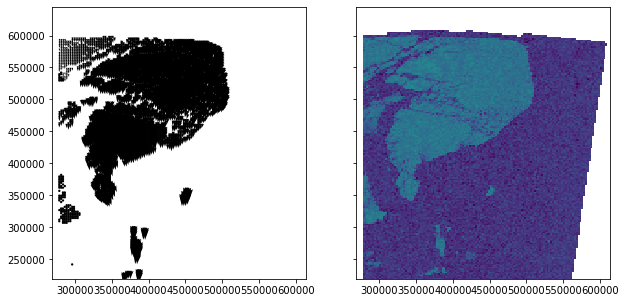

In [17]:
x, y = mod_dom.get_geolocation_grids(dst_srs=srs)

# show SAR-derived ice drift and quality metric (max cross-correlation times Hessian)
fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
stp = 1
gpi = gpi2
num_true_values = np.sum(gpi.data)
print(f"Number of True values without filtering : {num_true_values}")
axs[0].quiver(x[gpi][::stp], y[gpi][::stp], upm[gpi][::stp], vpm[gpi][::stp], width=0.01, scale=1000000)
#axs[1].quiver(x1pm[gpi][::stp], y1pm[gpi][::stp], upm[gpi][::stp], vpm[gpi][::stp], width=0.01, scale=1000000)
axs[1].pcolormesh(x, y, hpm, clim=[0, 25])
axs[0].set_xlim([x.min()-10000, x.max()-210000])
axs[0].set_ylim([y.min()+150000, y.max()-130000])
axs[1].set_xlim([x.min()-10000, x.max()-210000])
axs[1].set_ylim([y.min()+150000, y.max()-130000])

In [20]:
# Warp SAR1 with SAR-drift compenstaion
good_pixels = gpi2
mask_pm = ~good_pixels # mask out low quality or NaN
s1_dst_dom_S = warp_with_uv(n1_hv, n1_hv[1], mod_dom, upm, vpm, mask_pm, dst_dom)

# Warp SAR1 with model-drift compenstaion
#mask_mo = np.zeros(umo.shape, bool) # mask nothing
#s1_dst_dom_M = warp_with_uv(n1_hv, n1_hv[1], mod_dom, umo, vmo, mask_mo, dst_dom)

# Warp SAR2
s2_dst_dom = warp(n2_hv, n2_hv[1], dst_dom)

In [22]:
s1_mod_dom_S = warp_with_uv(n1_hv, n1_hv[1], mod_dom, upm, vpm, mask_pm, mod_dom)
s2_mod_dom = warp(n2_hv, n2_hv[1], mod_dom)

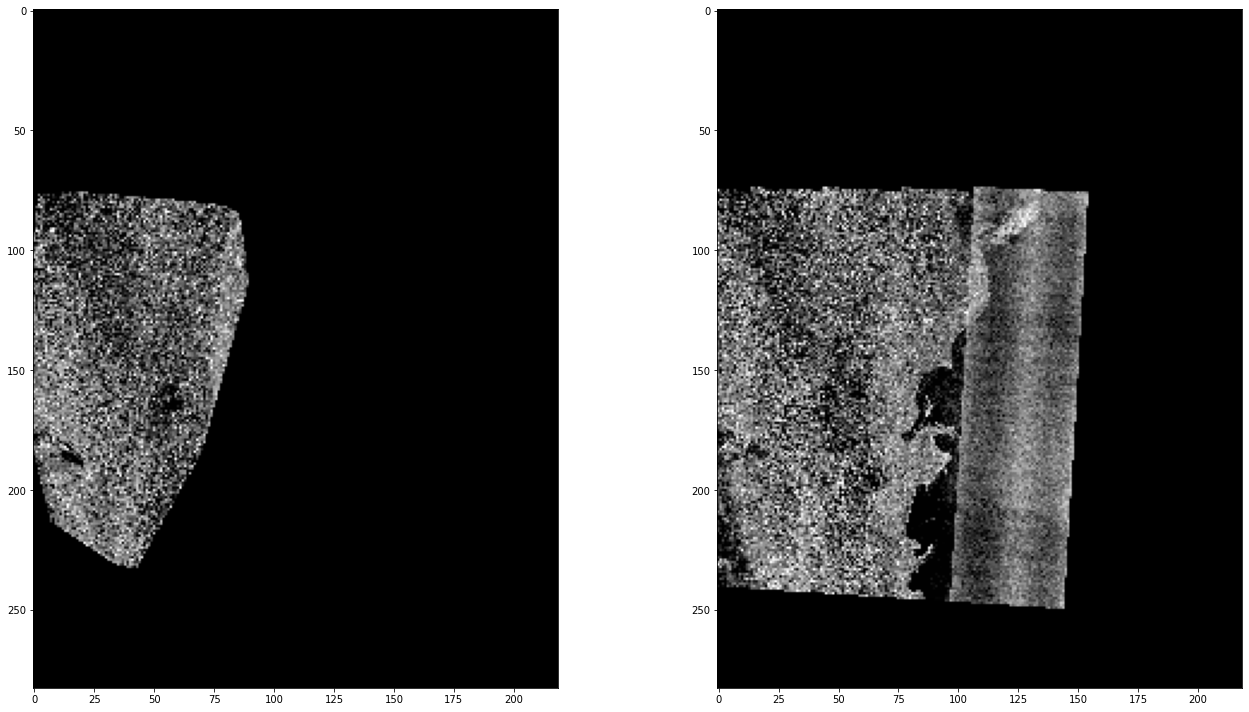

In [25]:
kwargs = dict(
    cmap='gray',
    clim=[0, 255],
)


fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].imshow(s1_mod_dom_S, **kwargs)
axs[1].imshow(s2_mod_dom, **kwargs)

plt.tight_layout()
plt.show()

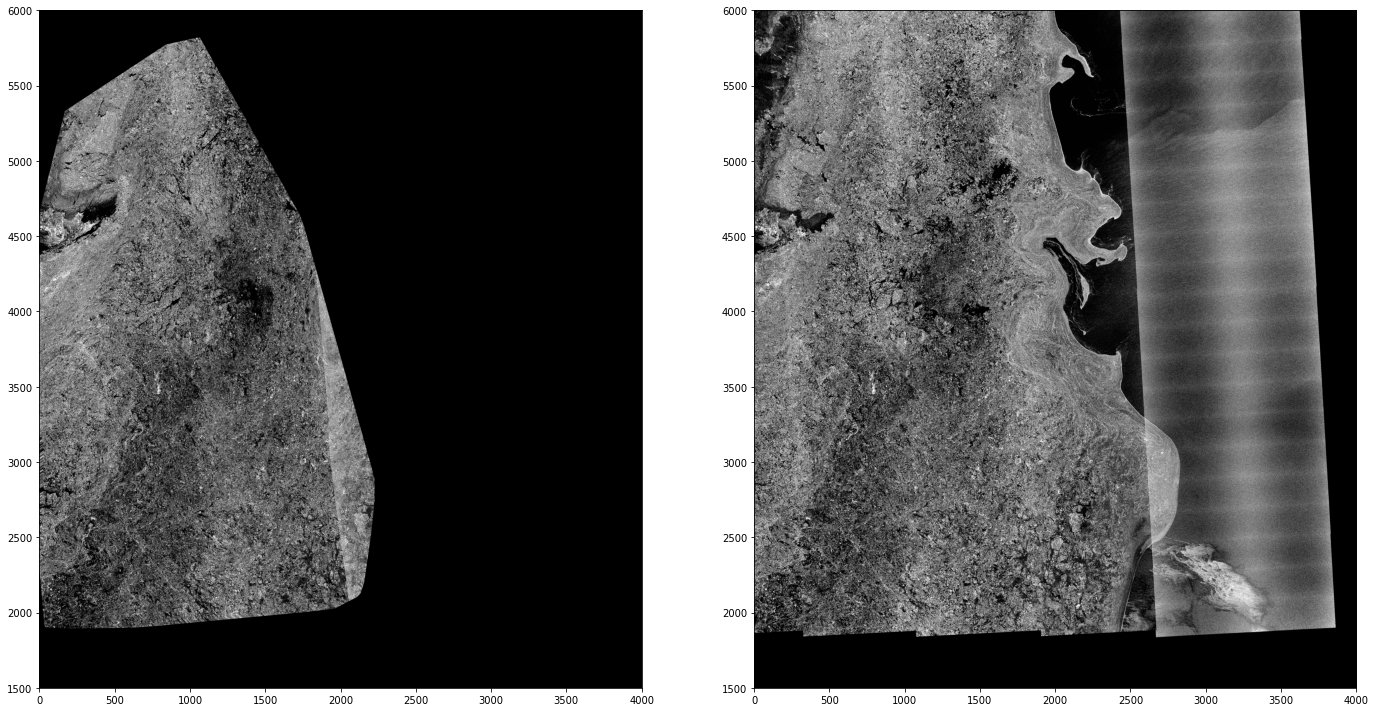

In [23]:
kwargs = dict(
    cmap='gray',
    clim=[0, 255],
)


fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].imshow(s1_dst_dom_S, **kwargs)
axs[1].imshow(s2_dst_dom, **kwargs)
axs[0].set_xlim([0, 4000])
axs[0].set_ylim([1500, 6000])
axs[1].set_xlim([0, 4000])
axs[1].set_ylim([1500, 6000])
plt.tight_layout()
plt.show()

In [19]:
# module


# ---------------------------------------------------------------------- #
# Name :        sar_ref_dirft_alignment.py
# Purpose :     Run the forecast using reference sar retrieved drift
# ---------------------------------------------------------------------- #

import matplotlib.pyplot as plt
from nansat import Nansat, Domain, NSR
import numpy as np
from scipy.interpolate import LinearNDInterpolator
#from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage import map_coordinates
from scipy.ndimage import distance_transform_edt


def get_dst_rows_cols(dst_dom):
    """ Create grids with row, column coordinates of the destination domain """
    rows2, cols2 = np.meshgrid(
        np.arange(0, dst_dom.shape()[0]),
        np.arange(0, dst_dom.shape()[1]),
        indexing='ij',
    )
    return rows2, cols2

def warp_with_rowcol(src_dom, src_img, c1, r1, c2, r2, dst_dom):
    """ Train interpolators of coordinates and apply to full resolution coordinates to computed a warped image """
    interp_r1 = LinearNDInterpolator(list(zip(r2, c2)), r1)
    interp_c1 = LinearNDInterpolator(list(zip(r2, c2)), c1)
    rows2, cols2 = get_dst_rows_cols(dst_dom)
    r1a = np.clip(interp_r1((rows2, cols2)), 0, src_dom.shape()[0])
    c1a = np.clip(interp_c1((rows2, cols2)), 0, src_dom.shape()[1])
    dst_img = map_coordinates(src_img, (r1a, c1a), order=0)
    return dst_img

def warp_distance(dst_dom, lon1, lat1, mask):
    """ Create a matrix with distance to the nearest valid drift and warp it onto the destination domain """
    c2_dist, r2_dist = dst_dom.transform_points(lon1.flatten(), lat1.flatten(), DstToSrc=1)
    mask_dist = distance_transform_edt(mask)
    interp_dist = LinearNDInterpolator(list(zip(r2_dist, c2_dist)), mask_dist.flatten())
    rows2, cols2 = get_dst_rows_cols(dst_dom)
    dst_dist = interp_dist((rows2, cols2))
    return dst_dist

def warp_with_lonlat(src_dom, src_img, lon1, lat1, lon2, lat2, dst_dom):
    """ Warp input image on destination domain if vectors of lon,lat source and destination points are knwown """
    c1, r1 = src_dom.transform_points(lon1.flatten(), lat1.flatten(), DstToSrc=1)
    c2, r2 = dst_dom.transform_points(lon2.flatten(), lat2.flatten(), DstToSrc=1)
    dst_img = warp_with_rowcol(src_dom, src_img, c1, r1, c2, r2, dst_dom)
    return dst_img

def warp(src_dom, src_img, dst_dom, step=None):
    """ Warp input image on destination domain (without drift compensation) """
    if step is None:
        step = int(src_dom.shape()[0]/100)
    src_lon, src_lat = src_dom.get_geolocation_grids(step)
    dst_img = warp_with_lonlat(src_dom, src_img, src_lon, src_lat, src_lon, src_lat, dst_dom)
    return dst_img

def warp_and_mask_with_lonlat(src_dom, src_img, lon1, lat1, lon2, lat2, mask, dst_dom, max_dist=2, fill_value=0):
    """ Warp input image on destination domain with drift compensation and masking if lon,lat,mask matrices are given """
    lon1v, lat1v, lon2v, lat2v = [i[~mask] for i in [lon1, lat1, lon2, lat2]]
    dst_img = warp_with_lonlat(src_dom, src_img, lon1v, lat1v, lon2v, lat2v, dst_dom)
    dst_dist = warp_distance(dst_dom, lon1, lat1, mask)
    dst_img[(dst_dist > max_dist) + np.isnan(dst_dist)] = fill_value
    return dst_img

def warp_with_uv(src_dom, src_img, uv_dom, u, v, mask, dst_dom):
    """ Warp input image on destination domain with drift compensation and masking if U,V,mask matrices are given """
    uv_srs = NSR(uv_dom.vrt.get_projection()[0])
    lon1uv, lat1uv = uv_dom.get_geolocation_grids()
    x1, y1, _ = uv_dom.vrt.transform_coordinates(NSR(), (lon1uv[~mask], lat1uv[~mask]), uv_srs)
    x2 = x1 + u[~mask]
    y2 = y1 + v[~mask]
    lon2uv, lat2uv, _ = uv_dom.vrt.transform_coordinates(uv_srs, (x2, y2), NSR())
    inp_img = np.array(src_img)
    inp_img[0] = 0
    inp_img[-1] = 0
    inp_img[:, 0] = 0
    inp_img[:, -1] = 0
    dst_img = warp_with_lonlat(src_dom, inp_img, lon1uv[~mask], lat1uv[~mask], lon2uv, lat2uv, dst_dom)
    return dst_img